In [ ]:
# 그래프에서 한글표현을 위해 폰트를 설치합니다.
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [ ]:
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)

plt.rc('font', family=font_name)

fm._rebuild()

NanumGothic Eco


In [ ]:
import re
import os
import unicodedata
import urllib3
import zipfile
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download the data


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/project/NLP_project/전처리/music_data_(35만_500자 제한)_re1.csv')

df

,Unnamed: 0,title,lyric
0,0,가,Follow me Here we go I go I go I go 난 완전히 go ...
1,1,가,어서와 포르쉐는 처음이지 yeah I bet that 억짜리 SUV white s...
2,2,잘 가,어서 가 밤이 깊었으니까 그래 조심히 들어가 그렇게 네가 사라질 때까지 손을 흔들...
3,3,가,참 선명한 얘기들 깨어도 깨어지지 않는 조각들 그뿐이란 걸 알면 이제 그만해도 될...
4,4,가,미안하다는 사과도 잘하겠다는 네 말도 지겨워 다 Over and over agai...
...,...,...,...
341318,341318,나 사는 이유 알도록,어린 시절 성탄 아침에 우린 많은 선물을 받았었지 하지만 몰랐었네 아기예수 탄생하...
341319,341319,나로부터 시작되리,저 높은 하늘위로 밝은 태양 떠오르듯이 난 주저앉지 않으리 어떤 어려움에도 주의 ...
341320,341320,나로부터 시작되리,저 높은 하늘 위로 밝은 태양 떠오르듯이 난 주저앉지 않으리 어떤 어려움에도 주의...
341321,341321,나로부터 시작되리,저 높은 하늘위로 밝은 태양 떠오르듯이 난 주저앉지 않으리 어떤 어려움에도 주의 ...


In [ ]:
df['title'].nunique(), df['lyric'].nunique()
df.drop_duplicates(subset=['lyric'], inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)

df

,Unnamed: 0,title,lyric
0,0,가,Follow me Here we go I go I go I go 난 완전히 go ...
1,1,가,어서와 포르쉐는 처음이지 yeah I bet that 억짜리 SUV white s...
2,2,잘 가,어서 가 밤이 깊었으니까 그래 조심히 들어가 그렇게 네가 사라질 때까지 손을 흔들...
3,3,가,참 선명한 얘기들 깨어도 깨어지지 않는 조각들 그뿐이란 걸 알면 이제 그만해도 될...
4,4,가,미안하다는 사과도 잘하겠다는 네 말도 지겨워 다 Over and over agai...
...,...,...,...
341318,341318,나 사는 이유 알도록,어린 시절 성탄 아침에 우린 많은 선물을 받았었지 하지만 몰랐었네 아기예수 탄생하...
341319,341319,나로부터 시작되리,저 높은 하늘위로 밝은 태양 떠오르듯이 난 주저앉지 않으리 어떤 어려움에도 주의 ...
341320,341320,나로부터 시작되리,저 높은 하늘 위로 밝은 태양 떠오르듯이 난 주저앉지 않으리 어떤 어려움에도 주의...
341321,341321,나로부터 시작되리,저 높은 하늘위로 밝은 태양 떠오르듯이 난 주저앉지 않으리 어떤 어려움에도 주의 ...


## Configuration


In [ ]:
batch_size = 32  # Batch size for training.
epochs = 100  # Number of epochs to train for.
hidden_units = 256  # Latent dimensionality of the encoding space.
embedding_dim = 100
num_samples = 341323    # Number of samples to train on.

## Prepare the data


데이터셋을 다운로드한 후에 데이터를 준비하고자 다음의 단계를 수행합니다.

1. 각 문장에 start와 end 토큰을 추가합니다.
2. 특정 문자를 제거함으로써 문장을 정리합니다.
3. 단어 인덱스와 아이디(ID) 인덱스를 생성합니다. (단어 → 아이디(ID), 아이디(ID) → 단어로 매핑된 딕셔너리).
4. 각 문장을 입력층의 최대 길이만큼 패딩(padding)을 수행합니다.

In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from konlpy.tag import Okt
okt = Okt()

In [ ]:
import re
def preprocess_kor_sentence(sent):
  # 단어와 구두점 사이에 공백을 만듭니다.
  # Ex) "he is a boy." => "he is a boy ."
  sent = re.sub(r"([?.!,¿])", r" \1", sent)

  # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환합니다.
  sent = re.sub(r"[^a-zA-Z가-힣ㄱ-ㅎㅏ-ㅣ!.?]+", r" ", sent)

  # 다수 개의 공백을 하나의 공백으로 치환
  sent = re.sub(r"\s+", " ", sent)
  
  sent = okt.morphs(sent, stem = False)
  sent = " ".join(sent) # string으로 출력!!! 구분 " "
  return sent

In [ ]:
from tqdm import tqdm 
def load_preprocessed_data():
    encoder_input, decoder_input, decoder_target = [], [], []

    for i in tqdm(range(len(df[:num_samples]))):
        # source 데이터와 target 데이터 분리
        tar_line = df['title'].iloc[i]
        src_line = df['lyric'].iloc[i]

        # source 데이터 전처리
        src_line = [w for w in preprocess_kor_sentence(src_line).split()]

        # target 데이터 전처리
        tar_line = preprocess_kor_sentence(tar_line)
        tar_line_in = [w for w in ("<sos> " + tar_line).split()]  # teacher forcing을 위한 정답셋 
        tar_line_out = [w for w in (tar_line + " <eos>").split()]

        encoder_input.append(src_line)
        decoder_input.append(tar_line_in)
        decoder_target.append(tar_line_out)
                
    return encoder_input, decoder_input, decoder_target

In [ ]:
# 전처리 테스트

kr_sent = u"저녁 먹었니?"

print('전처리 전 한국어 문장 :', kr_sent)
print('전처리 후 한국어 문장 :', preprocess_kor_sentence(kr_sent))

전처리 전 한국어 문장 : 저녁 먹었니?
전처리 후 한국어 문장 : 저녁 먹었니 ?


In [ ]:
sents_lylic_in, sents_title_in, sents_title_out  = load_preprocessed_data()

100%|██████████| 341323/341323 [6:59:52<00:00, 13.55it/s]


In [ ]:
len(sents_lylic_in), len(sents_title_in), len(sents_title_out)

(341323, 341323, 341323)

In [ ]:
print('인코더의 입력 :',sents_lylic_in[2968])
print('디코더의 입력 :',sents_title_in[2968])
print('디코더의 레이블 :',sents_title_out[2968])

인코더의 입력 : ['궂', '은', '비', '내리는', '날', '그야말로', '옛날', '식', '다방', '에', '앉아', '도라지', '위스키', '한', '잔', '에다', '짙은', '색소폰', '소릴', '들어', '보렴', '새', '빨', '간', '립스틱', '에', '나름', '대로', '멋', '을', '부린', '마담', '에게', '실없이', '던지는', '농담', '사이', '로', '짙은', '색소폰', '소릴', '들어', '보렴', '이제', '와', '새삼', '이', '나이', '에', '실연', '의', '달콤함이야', '있', '겠냐만은', '왠지', '한', '곳', '이', '비어', '있는', '내', '가슴', '이', '잃어버린', '것', '에', '대하', '여', '밤', '늦은', '항구', '에서', '그야말로', '연락선', '선', '창가', '에서', '돌아올', '사람', '은', '없을지라도', '슬픈', '뱃고동', '소릴', '들어', '보렴', '첫사랑', '그', '소녀', '는', '어디', '에서', '나', '처럼', '늙어', '갈까', '가버린', '세월', '이', '서글퍼지는', '슬픈', '뱃고동', '소릴', '들어', '보렴', '이제', '와', '새삼', '이', '나이', '에', '청춘', '의', '미련', '이야', '있', '겠냐만은', '왠지', '한', '곳', '이', '비어', '있는', '내', '가슴', '에', '다시', '못', '올', '곳', '에', '대하', '여', '낭만', '에', '대하', '여', 'kia']
디코더의 입력 : ['<sos>', '낭만', '에', '대하', '여']
디코더의 레이블 : ['낭만', '에', '대하', '여', '<eos>']


단어집합을 생성하겠습니다. 

In [ ]:
# 가사 input -> 제목 output 

# 가사 input

tokenizer_lylic = Tokenizer(filters="", lower=False)
tokenizer_lylic.fit_on_texts(sents_lylic_in)
encoder_input = tokenizer_lylic.texts_to_sequences(sents_lylic_in)

In [ ]:
# 제목 output
tokenizer_title = Tokenizer(filters="", lower=False)
tokenizer_title.fit_on_texts(sents_title_in)
tokenizer_title.fit_on_texts(sents_title_out)

decoder_input = tokenizer_title.texts_to_sequences(sents_title_in)
decoder_target = tokenizer_title.texts_to_sequences(sents_title_out)

각 문장을 입력층의 최대 길이만큼 패딩(padding)을 수행합니다. 

In [ ]:
encoder_input = pad_sequences(encoder_input,maxlen=1500, padding="post")
decoder_input = pad_sequences(decoder_input,maxlen=8, padding="post")
decoder_target = pad_sequences(decoder_target,maxlen=8, padding="post")

In [ ]:
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)

인코더의 입력의 크기(shape) : (341323, 1500)
디코더의 입력의 크기(shape) : (341323, 8)
디코더의 레이블의 크기(shape) : (341323, 8)


샘플은 총 3833개 존재합니다


In [ ]:
src_vocab_size = len(tokenizer_lylic.word_index) +1
tar_vocab_size = len(tokenizer_title.word_index) +1

print(f"가사 단어 집합의 크기 : {src_vocab_size}, 제목 단어 집합의 크기 : {tar_vocab_size}")

가사 단어 집합의 크기 : 420224, 제목 단어 집합의 크기 : 84752


In [ ]:
len(tokenizer_title.word_index)

84751

단어로부터 정수를 얻는 딕셔너리와 정수로부터 단어를 얻는 딕셔너리를 각각 만들어줍니다. 이들은 훈련을 마치고 예측값과 실제값을 비교하는 단계에서 사용합니다. 

In [ ]:
src_to_index = tokenizer_lylic.word_index  # word : idx
index_to_src = tokenizer_lylic.index_word  # idx : word
tar_to_index = tokenizer_title.word_index # word : idx
index_to_tar = tokenizer_title.index_word # idx : word

In [ ]:
print(len(src_to_index),len(index_to_src),len(tar_to_index),len(index_to_tar))


420223 420223 84751 84751


테스트 데이터를 분리하겠습니다. 인코더 input, 디코더 input, 디코더 output이 동일하게 분리되어야 하기 때문에 랜덤한 정수배열을 만들어 직접 나누겠습니다. 

우선 랜덤하게 시퀀스를 섞습니다. 

In [ ]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)

랜덤 시퀀스 : [ 22035 154545 339227 ... 193369 212072  83491]


In [ ]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [ ]:
decoder_input[indices[0]], decoder_target[indices[0]]

(array([   1,    9, 1247, 5845,  138,    0,    0,    0], dtype=int32),
 array([   9, 1247, 5845,  138,    2,    0,    0,    0], dtype=int32))

`<sos>` `<eos>` 토큰을 제외한 다른 단어들은 동일한 인덱스를 갖고 있어야 합니다. 

10%의 데이터를 test데이터로 분리하겠습니다. 

In [ ]:
n_of_val = int(num_samples*0.1)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [ ]:
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

훈련 source 데이터의 크기 : (307191, 1500)
훈련 target 데이터의 크기 : (307191, 8)
훈련 target 레이블의 크기 : (307191, 8)
테스트 source 데이터의 크기 : (34132, 1500)
테스트 target 데이터의 크기 : (34132, 8)
테스트 target 레이블의 크기 : (34132, 8)


## Model

이제 번역기를 빌드해보겠습니다. 

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

인코더를 설계합니다. LSTM에서 state_h, state_c를 리턴받는데, 이는 각각 RNN 챕터에서 LSTM을 처음 설명할 때 언급하였던 은닉 상태와 셀 상태에 해당됩니다. 이 두 가지 상태를 encoder_states에 저장합니다. encoder_states를 디코더에 전달하므로서 이 두 가지 상태 모두를 디코더로 전달할 예정입니다. 이것이 앞서 배운 컨텍스트 벡터입니다.

In [ ]:
# 인코더
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(src_vocab_size, embedding_dim)(encoder_inputs) # 임베딩 층
encoder_lstm1 = LSTM(hidden_units, return_sequences = True, return_state=True)
encoder_lstm2 = LSTM(hidden_units, return_sequences = True, return_state=True)
encoder_lstm3 = LSTM(hidden_units, return_sequences = True, return_state=True)

x, eh1, ec1 = encoder_lstm1(enc_emb) # 은닉 상태와 셀 상태를 리턴
x, eh2, ec2 = encoder_lstm2(x) # 은닉 상태와 셀 상태를 리턴
encoder_outputs, eh3, ec3 = encoder_lstm3(x) # 은닉 상태와 셀 상태를 리턴

encoder_states = [eh1, ec1, eh2, ec2, eh3, ec3] # 인코더의 은닉 상태와 셀 상태를 저장

이번에는 Attention을 추가합니다. 
- Attention 중 가장 기초적인 dot-product attention을 예제로 진행하겠습니다. 
1. attention score 계산
2. softmax로 attention distribution 계산
3. 각 인코더의 어텐션 가중치와 은닉 상태를 가중합하여 어텐션 값 계산
4. 어텐션값과 디코더의 t시점의 은닉상태를 연결
5. 출력층 연산의 입력이 되는 st 계산

디코더에서는 attention layer를 추가합니다. 
- 이때, s_는 은닉상태와 디코더의 최종 출력은 연결해야 하므로, shape을 맞춰주기 위하여 축을 추가합니다. 
- attention layer는 디코더의 은닉상태와 인코더의 은닉상태 전체를 받아 컨텍스트 벡터를 생성합니다. 
- 마지막으로 생성한 컨텍스트 벡터와 디코더의 은닉상태 전체를 softmax layer에 넣고 인덱스를 예측합니다. 


In [ ]:
from tensorflow.keras.layers import Attention

# 디코더
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, hidden_units) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 임베딩 결과

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm1 = LSTM(hidden_units, return_sequences=True, return_state=True) 
decoder_lstm2 = LSTM(hidden_units, return_sequences=True, return_state=True) 
decoder_lstm3 = LSTM(hidden_units, return_sequences=True, return_state=True) 

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
x1, h1, c1 = decoder_lstm1(dec_emb, initial_state=encoder_states[:2])
x2, h2, c2 = decoder_lstm2(x1, initial_state=encoder_states[2:4])
decoder_outputs, h3 , c3 = decoder_lstm3(x2, initial_state=encoder_states[4:])

# attention
S_ = tf.concat([eh3[:, tf.newaxis, :], decoder_outputs[:, :-1, :]], axis=1) # query 

attention = Attention(hidden_units)
context_vector, _ = attention([S_, encoder_outputs], return_attention_scores = True)

concat = tf.concat([decoder_outputs, context_vector], axis=-1)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(concat)

In [ ]:
# 모델의 입력과 출력을 정의.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 100)    42022400    ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    21696512    ['input_2[0][0]']                
                                                                                              

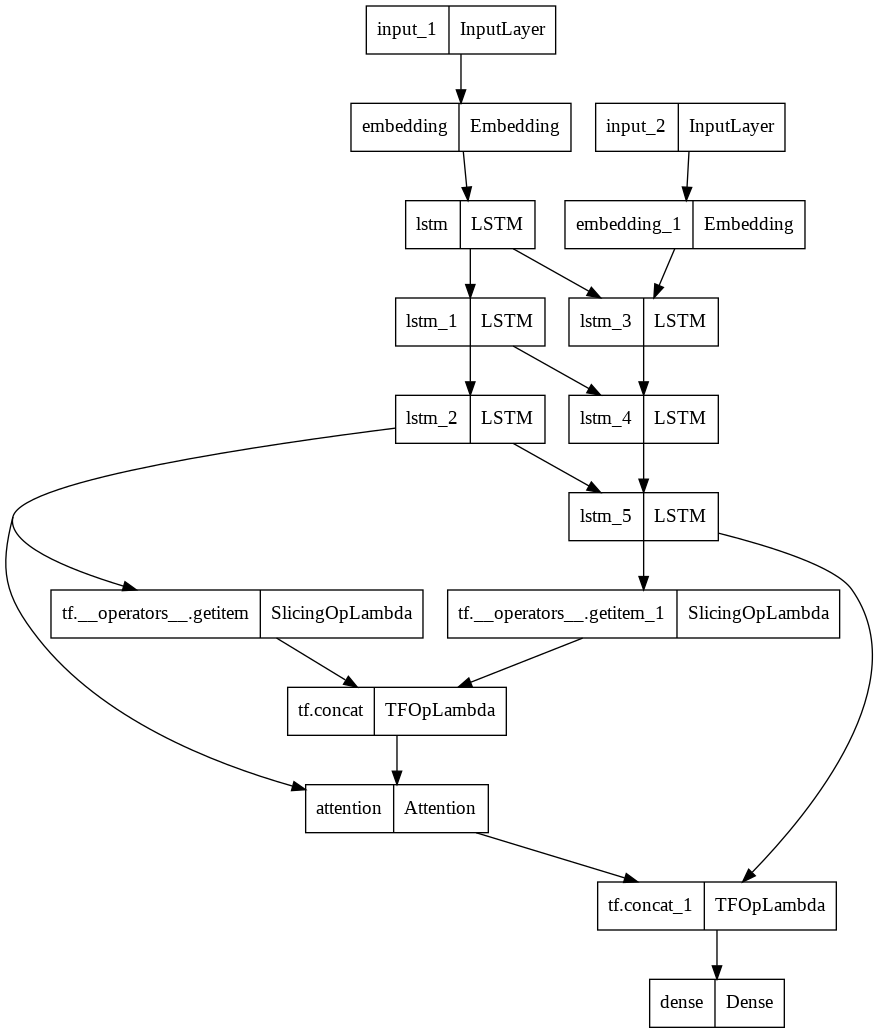

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', )

In [ ]:
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, 
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),batch_size=64, epochs=10)

Epoch 1/10
4800/4800 [==============================] - 2641s 550ms/step - loss: 3.1394 - acc: 0.6199 - val_loss: 2.9808 - val_acc: 0.6281
Epoch 2/10
4800/4800 [==============================] - 2637s 549ms/step - loss: 2.7516 - acc: 0.6347 - val_loss: 2.7938 - val_acc: 0.6405
Epoch 3/10
4800/4800 [==============================] - 2637s 549ms/step - loss: 2.4820 - acc: 0.6484 - val_loss: 2.6916 - val_acc: 0.6520
Epoch 4/10
4800/4800 [==============================] - 2638s 550ms/step - loss: 2.2487 - acc: 0.6624 - val_loss: 2.6488 - val_acc: 0.6594
Epoch 5/10
4800/4800 [==============================] - 2640s 550ms/step - loss: 2.0449 - acc: 0.6756 - val_loss: 2.6580 - val_acc: 0.6626
Epoch 6/10
4800/4800 [==============================] - 2641s 550ms/step - loss: 1.8738 - acc: 0.6884 - val_loss: 2.6896 - val_acc: 0.6638
Epoch 7/10
4800/4800 [==============================] - 2640s 550ms/step - loss: 1.7018 - acc: 0.7039 - val_loss: 2.7266 - val_acc: 0.6660
Epoch 8/10
4800/4800 [=====

In [ ]:
model.save('/content/drive/MyDrive/nlp_project/model/songTolyric/lstm_attention_model_9/17(2).h5')

## 훈련된 모델로 번역하기

* 평가 함수는 여기서 *교사 강요(teacher forcing)*를 사용하기 못하는 것을 제외하고는 훈련 루프와 비슷합니다. 각 마지막 시점(time step)에서 이전 디코더 인코더의 결과와 은닉 상태(hidden state)를 가진 예측 값을 디코더에 입력합니다.

    1. 번역하고자 하는 입력 문장이 인코더로 입력되어 인코더의 마지막 시점의 은닉 상태와 셀 상태를 얻습니다.
    2. 인코더의 은닉 상태와 셀 상태, 그리고 토큰 <sos>를 디코더로 보냅니다.
    3. 디코더가 토큰 <eos>가 나올 때까지 다음 단어를 예측하는 행동을 반복합니다.

In [ ]:
# 인코더 - 훈련과 동일 
encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states])

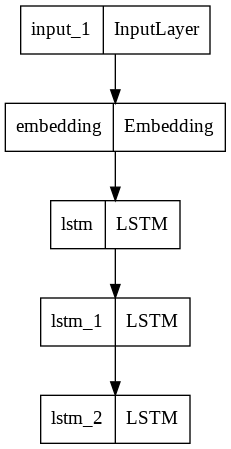

In [ ]:
tf.keras.utils.plot_model(encoder_model, to_file='model.png', )

In [ ]:
# 디코더 

# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))

decoder_state_input_h1 = Input(shape=(hidden_units,))
decoder_state_input_c1 = Input(shape=(hidden_units,))

decoder_state_input_h2 = Input(shape=(hidden_units,))
decoder_state_input_c2 = Input(shape=(hidden_units,))


decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c,
                         decoder_state_input_h1, decoder_state_input_c1,
                         decoder_state_input_h2, decoder_state_input_c2]


encoder_state_h = Input(shape=(hidden_units,))
encoder_outputs2 = Input(shape =(None, hidden_units,))


# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
x, state_h1, state_c1 = decoder_lstm1(dec_emb2, initial_state=decoder_states_inputs[:2])
x, state_h2, state_c2 = decoder_lstm2(x, initial_state=decoder_states_inputs[2:4])
decoder_outputs2, state_h3, state_c3 = decoder_lstm3(x, initial_state=decoder_states_inputs[4:])
decoder_states2 = [state_h1, state_c1, state_h2, state_c2, state_h3, state_c3]
# decoder_states2 = [state_h, state_c]

# Attention
S_ = tf.concat([encoder_state_h[:, tf.newaxis, :], decoder_outputs2[:, :-1, :]], axis=1) # query 

context_vector, att_score = attention([S_, encoder_outputs2], return_attention_scores = True)
decoder_concat = tf.concat([decoder_outputs2, context_vector], axis=-1)

# 모든 시점에 대해서 단어 예측 (Fully Connected)
decoder_outputs2 = decoder_dense(decoder_concat)

# 수정된 디코더
decoder_model = Model(
    [decoder_inputs, encoder_state_h, encoder_outputs2] + decoder_states_inputs,
    [decoder_outputs2, att_score] + decoder_states2)

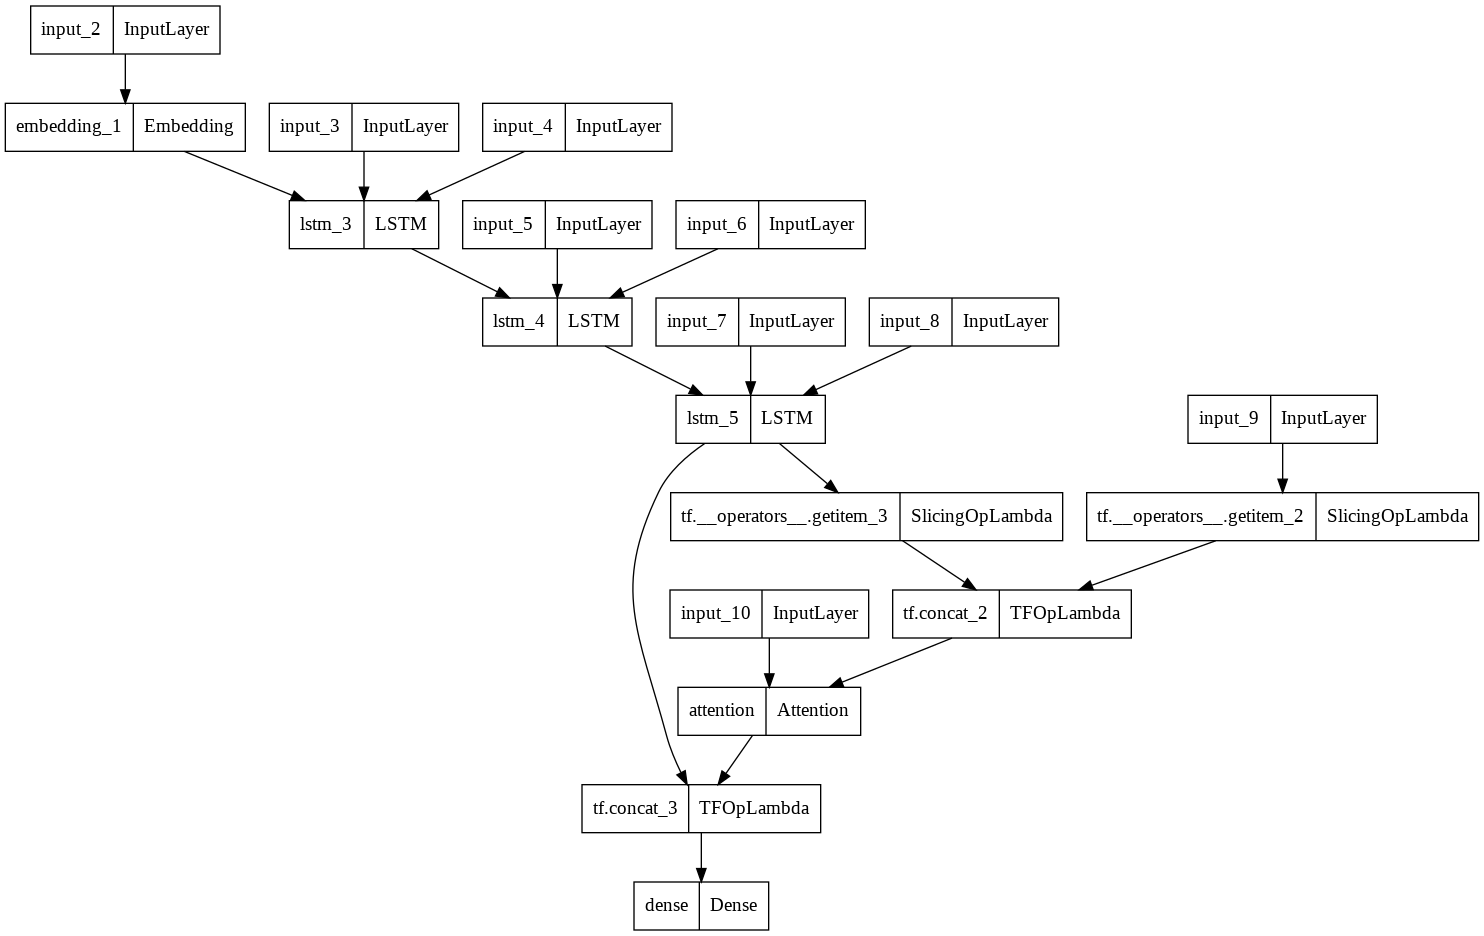

In [ ]:
tf.keras.utils.plot_model(decoder_model, to_file='model.png', )

테스트 단계에서의 동작을 위한 decode_sequence 함수를 구현합니다. 
1. 입력 문장이 들어오면 인코더는 마지막 시점까지 전개하여 마지막 시점의 은닉 상태와 셀 상태를 리턴합니다. -> `states_value` 
2. 디코더의 초기 입력으로 <SOS>를 준비합니다. -> `target_seq`
3. 이 두 가지 입력을 가지고 while문 안으로 진입하여 이 두 가지를 디코더의 입력으로 사용합니다. 
4. 이제 디코더는 현재 시점에 대해서 예측합니다. 
    - 예측 벡터로부터 현재 시점의 예측 단어인 target_seq를 얻고, h와 c 이 두 개의 값은 states_value에 저장합니다. 
    - while문의 다음 루프. 즉, 두번째 시점의 디코더의 입력으로 다시 target_seq와 states_value를 사용합니다. 
    - 이를 현재 시점의 예측 단어로 <eos>를 예측하거나 번역 문장의 길이가 50이 넘는 순간까지 반복합니다. 
5. 각 시점마다 번역된 다어는 decoded_sentence에 누적하여 저장하였다가 최종 번역 시퀀스로 리턴합니다.

In [ ]:
def decode_sequence(sentence):
    # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
    max_src_len, max_tar_len  = encoder_input.shape[1], decoder_input.shape[1]

    attention_plot = np.zeros((max_tar_len, max_src_len))

    sentence = preprocess_kor_sentence(sentence)
    tokens = sentence.split(" ")
    inputs = tokenizer_lylic.texts_to_sequences([tokens])

    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                            maxlen=max_src_len,
                                                            padding='post')
    encoder_test, states_value = encoder_model.predict(inputs)

    # <SOS>에 해당하는 정수 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_to_index['<sos>']
    
    stop_condition = False
    decoded_sentence = ''

    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    for t in range(max_tar_len):
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, att_score, h1, c1, h2, c2, h3, c3 = decoder_model.predict([target_seq, states_value[0], encoder_test] + states_value)
        # tar_to_index 2808
        # output_tokens 왜오ㅓㅐ오애ㅗ애2089??????
  

        # 어텐션 가중치 시각화를 위해 저장 
        att_score = tf.reshape(att_score, (-1, ))
        attention_plot[t] = att_score.numpy() 

        # 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]
  
        # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char


        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [ h1, c1, h2, c2, h3, c3]

        # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
        if sampled_char == '<eos>':
            break 

    return sentence, decoded_sentence, attention_plot

결과 확인을 위한 함수를 만듭니다.

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + index_to_src[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != tar_to_index['<eos>']):
    # if(encoded_word != 0 and encoded_word != tar_to_index['<sos>'] and encoded_word != tar_to_index['<eos>']):
      sentence = sentence + index_to_tar[encoded_word] + ' '
  return sentence

In [ ]:
from pylab import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_attention(attention, sentence, predicted_sentence):
    # you need to change the fname based on your system, and the Chinese can be displayed in the plot
    # font = FontProperties(fname=r"./data/TaipeiSansTCBeta-Regular.ttf", size=14)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    # set the x-tick/y-tick labels with list of string labels
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation = 90)
    ax.set_yticklabels(predicted_sentence, fontdict=fontdict)

    # set tick locators
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

In [ ]:
def translate(sentence):
  sentence, result, attention_plot = decode_sequence(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

"""  attention_plot = attention_plot[:len(result.split(' '))-2, :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))"""

"  attention_plot = attention_plot[:len(result.split(' '))-2, :len(sentence.split(' '))]\n  plot_attention(attention_plot, sentence.split(' '), result.split(' '))"

In [ ]:
translate('번역기를 만드는 것은 재미있어.')

Input: 번역기 를 만드는 것 은 재미있어 .
Predicted translation:  <eos>


In [ ]:
translate('집에 가고 싶다.')

Input: 집 에 가고 싶다 .
Predicted translation:  가 <eos>


In [ ]:
translate('당신의 직업은 무엇입니까?')

Input: 당신 의 직업 은 무엇 입 니까 ?
Predicted translation:  <eos>


In [ ]:
def translate_train(seq_index):
  input_seq = encoder_input_train[seq_index: seq_index + 1]

  sentence = seq_to_src(encoder_input_train[seq_index]).strip()
  _, result, attention_plot = decode_sequence(sentence)

  print('Input: %s' % (sentence))
  print("Right translation :",seq_to_tar(decoder_input_train[seq_index]))
  print('Predicted translation: {}'.format(result))

"""  attention_plot = attention_plot[:len(result.split(' '))-2, :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))"""

"  attention_plot = attention_plot[:len(result.split(' '))-2, :len(sentence.split(' '))]\n  plot_attention(attention_plot, sentence.split(' '), result.split(' '))"

In [ ]:
translate_train(11)

Input: oh my love you re my dream 나 는 영원히 너 를 사랑 해요 힘 이 들 때 지칠 때 군말 없이 내 곁 에 있어 줬지 기쁨 도 슬픔 도 모두 다 같이 골목 대장 시절 이 그리워질 때 나와 함께 옛 추억 에 추억 에 흠뻑 젖 을 수 있네 너 와 함께 석양 을 바라보며 나 술 한잔 해 어떡하나 친구 한잔 하게 친구 옛 생각 에 친구 우린 기억 하네 친구 중학교 다닐 때 머리 를 기르고 싶어서 아침 에 일찍 일어나 나 무섭던 선생님 을 피해 걸리지 않았던 기쁨 에 주위 에서 바라보던 친구 들 부러운 시선 을 샀던 그 때 머리 가 길어야 멋있는 줄 알았던 어렸던 그 때 어느 날 갑자기 짧아진 니 머리 아무 말 없이 웃으며 다음 날 또 다시 짧아진 니 머리 그 래야 넌 나 의 친구 야 친구 따라 강남 갔던 내 가 바로 나 바로 나 였구나 바로 나 였나보다 내게 힘 이 돼 주던 내게 믿음 이 돼 주던 내게 소중함이란 무엇 인지 가르쳐주던 우리 는 자랐네 어느새 어른 이 돼 가네 친구여 영원
Right translation : <sos> 친구 feat . Eugene 
Predicted translation:  나 의 하루 <eos>


In [ ]:
for seq_index in [10, 203, 500, 900, 8003]:
  translate_train(seq_index)
  print("-"*50)

Input: 난 그냥 가볍게 봤고 해보자는 친구 의 말 도 너무 달콤하게 느껴져 처음 찾아 갔던 학원 거기 몇 년 꼴아 박고 나 는 하루 종일 작업 바람 넣은 친구 새끼 들 은 진작 도망갔고 아마 다시 돌아가면 찾겠지 다른 방법 근데 지금 이 그 때 덕인 건 입 아프지 두 말 하 면 그때 처럼 사는 건 나 는 엄두 도 안 나 이 젠 책임질 시간 들 이 너무나도 많기에 흔적 도 없이 사라진 나 의 첫 번째 무리 우린 그 빌어먹을 꿈 이 밥 먹여 준 듯이 그 때 가 그리운 건 나이테 를 줄이 고픈 알량한 마음 이 아닌 건 말 안 해도 다 느껴주길 말 은 못 해도 느꼈던 그 감정 하루 열 시간 을 뱉게 해주던 거 아침 에 눈 을 띄우고 날 움직였던 지금 의 그것 과는 다른 My shit is love 그 좆 같은 게 지금 은 나를 미치게 해도 없으면 안 되는 거더 라고 몇 일밤 을 세우고 메모장 을 억지로 채워 내고 다음 날 지우는 패턴 에 지쳐 갈 때 쯤 찾아 낸 옛날 의 공책 속 말 도 안 되는 가사 들 을 적어가며 무엇 보다
Right translation : <sos> love 
Predicted translation:  I Don t Know <eos>
--------------------------------------------------
Input: 이쿠 지 다이카 가 아리 마시테 카나시 코토 가 오 코 리마 시타 여러 시 대가 있어서 슬픈 일이 일어났습니다 . 모 시라 나이 후리 와 데키나이 요 보 쿠라 와 싯테 시 맛 타카라 더 는 모르는 척 은 할 수 없어 . 우리 는 알 아 버렸으니까 아타리 마에노 코토 난 데스 가 히 비 와 나 가루 나 가루 나 가루 당연한 일이 지만 나날 은 흘러간다 흘러간다 흘러간다 키카 자루 몬 가 나쿠낫테 캇코 츠케루몬 가 나쿠낫테 화려하게 치장 할 게 없어져서 무게 잡 을 게 없어져서 하다 카노 코코 로데 무 카이 아우 손 나 토키 가 키탓테 키가스루 요 맨 마음 으로 맞이 할 그런 때 가 왔다는 느낌 이 들어 . 

In [ ]:
def translate_test(seq_index):
  input_seq = encoder_input_test[seq_index: seq_index + 1]

  sentence = seq_to_src(encoder_input_test[seq_index]).strip()
  _, result, attention_plot = decode_sequence(sentence)

  print('Input: %s' % (sentence))
  print("Right translation :",seq_to_tar(decoder_input_train[seq_index]))
  print('Predicted translation: {}'.format(result))

  #attention_plot = attention_plot[:len(result.split(' '))-2, :len(sentence.split(' '))]
  #plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: 네 게 말 하지 않았죠 널 사랑 한다고 또 미워한다고 오래전 부터 그리워 했다고 그땐 몰랐던거죠 내 둔한 마음 이 알 수 없어서 빗겨 간거죠 돌이킬 수 는 없는거죠 쉽게 널 만 날수 가 있다면 내 안 에 모든 슬픔 이 사라지겠죠 하지만 난 그럴수가 없어요 미안해요 내 마음 을 이해 해줘요 미안해요 지난 시간 속 에 뒤늦은 나 의 마음 을 줄 수 없네요 기다려요 내 아픔 이 상처 없이 아물 때 그대 에게 갈께요 쉽게 널 만 날수 가 있다면 내 안 에 모든 슬픔 이 사라지겠죠 하지만 난 그럴수가 없어요 미안해요 내 마음 을 이해 해줘요 미안해요 지난 시간 속 에 뒤늦은 나 의 마음 을 줄 수 없네요 기다려요 내 아픔 이 상처 없이 아물 때 그대 에게 갈께요 미안해요 지난 시간 속 에 뒤늦은 나 의 마음 을 줄 수 없네요 기다려요 내 아픔 이 상처 없이 아물 때 그대 에게 갈께요 f r
Right translation : <sos> love 
Predicted translation:  화분 <eos>


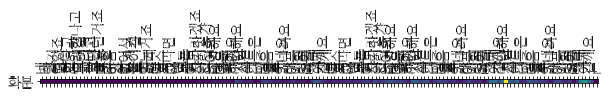

--------------------------------------------------
Input: 산위 에 올라 세상 을 보네 산위 에 올라 발아 래 세상 을 보네 이렇게 내려다보면 아무 생각 이 없네 어둠 이 와도 혼자 남았네 너무 어두워 아무 도 보이지 않네 갑자기 외로워져서 소리소리 질렀네 소리 질러도 대답 이 없네 소리 질러도 아무 도 와 주지 않네 나 만 남겨진 채 로 시간 마저 멈췄네
Right translation : <sos> You feat . 순하니 
Predicted translation:  한 번만 <eos>


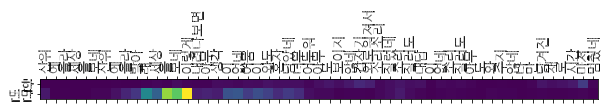

--------------------------------------------------
Input: 새끼 손가락 걸 며 영원하자던 그대 는 지금 어디 에 그대 를 사랑 하며 잊어 야하는 내 맘 은 너무 아파요 그대 떠나는 뒷 모습 에 내 눈물 떨구어주리 가던 걸음 에 내 눈물 떨구어 주 리 내 마음 보여줘 본 그때 그 사람 사랑 하던 나 의 그 사람 뜨거운 내 마음 은 나도 모르게 천천히 식어 갑니다 세월 이 흘러가서 백발 이 되어 버리고 얼굴 엔 주름 지어 내사 랑 식어 버려도 내 마음 보여줘 본 그때 그 사람 사랑 하던 나 의 그 사람 뜨거운 내 마음 은 나도 모르게 천천히 식어 갑니다 에헤 에
Right translation : <sos> 밤샜지 Prod . By Zico 
Predicted translation:  추억 만들기 <eos>


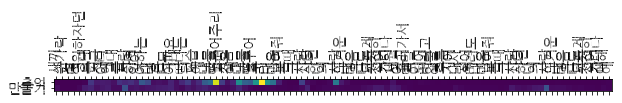

--------------------------------------------------
Input: 아마 나 만 다른 길 인가 봐 조마조마 맘 을 졸여 끝 을 떠는 나침반 을 쥐 고 이리저리 마구 흔들려 짜릿하고 신나지만 조바심 도 같은 무게 한 발 더 한 발 더 그래 일단 Go 물음표 투성이 미로 정답 이 따로 없는 quiz 채점 은 아주 먼 훗날 그 마저도 내 가 나 에게 되 물 을 뿐 어떤 말 을 건네게 될까 시간 너머 이 길 의 끝 에서 마주 할 그날 의 내게 We re all single riders 함께여도 외로운 여행 빈칸 만 가득한 지도 와 편도 의 ticket 청춘 꿈꾸는 Traveler 닿을 곳 을 모르는 비행 우리 어디 쯤 날 고 있을까 또 헛걸음 해 속 끓이며 헤매던 길 에 또 이리 덩 그러니 잰 걸음 에 발 덜그럭 대 젊음 이란 다 그런 거 라는 데 뭐라 뭐라 멋진 말 은 많아 뭐라는진 아직 잘은 몰라 별 을 어깨 에 메고 무한 의 삼각 계단 끝없이 오르고 내리는 아이 가 돼 붉은 사막 의 off road 오목 이 패인 새 카 만 늪 쉬는 곳도 길잡이 도 묘 해 그럴 때 는 눈 에 또 띄질 않아
Right translation : <sos> Black Mirror 
Predicted translation:  누워서 <eos>


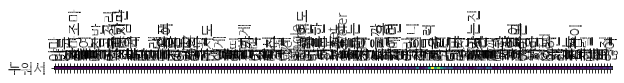

--------------------------------------------------


In [ ]:
for seq_index in [10, 200, 303, 1005]:
  translate_test(seq_index)
  print("-"*50)

# train


In [ ]:
len(encoder_input_train)

307191

In [ ]:
for seq_index in range(100000):
  translate_train(seq_index)
  print("-"*50)

Input: 운동화 신고 서 나 걸어 볼까 One step 운동화 벗고서 나 뛰어 볼까 Two Step 나 어디 든 가볼래 좀 내버려 둬 다른 생각 들 은 넣어 둬 오늘 내 가 갈 곳 은 아마도 어쩌면 운동화 신고 서 나 걸어 볼까 One step One Two step Oh Oh 오늘 밤 나가서 나 춤춰 볼까 Good night or Good morning 처음 보는 그 애 랑 놀고 싶어 뭘 해도 재밌을 것 같아 Oh 오늘 밤 너 의 팔 과 나 의 팔이 마주 볼 때 한 바퀴 빙글 돌고 싶어 Oh 밤새도록 빙그르르 Oh 빙그르르 한 바퀴 Oh oh oh 두 바퀴 또 다른 새로운 걸 로 시작 할까 시작 할래 아직도 준비 가 필요한 넌 그냥 집 으로 가 운동화 벗고서 나 뛰어 볼까 One round One Two round 넌 왼손 을 들어 난 오른손 을 올릴게 Highfive yeah 기분 이 좋아 처음 보는 그 애 랑 놀고 싶어 뭘 해도 재밌을 것 같아 Oh 오늘 밤 너 의 팔 과 나 의 팔이 마주 볼
Right translation : <sos> HIGH FIVE 
Predicted translation:  New Year <eos>
--------------------------------------------------
Input: 나 의 기본 값 은 모두 에게 친절 이지만 딱 거기 까지 날 도형 으로 말 하자면 동그라미 거기 점 두 개 입 엔 나이키 로고 물론 그건 처음 에 너 에게도 예외 는 없지 속 으로는 심장 에 타격 을 입지 조금 은 겁나지만 멈추지 않아 내 선 을 넘어 니 선 에 직진 우리 는 필요해 교집합 이 보단 필요해 일부분 그게 더 커 같지만 약간 은 다른 취향 되려 좋지 그 모습 을 내게만 보여줘 나도 남 들 에겐 단면 너 에게 만은 D 겉 으로 물렁거려 도 철벽 이 높지 이제 그 어진 선 안 에는 너 의 지 분 이 어쩌면 나 보다 높지 이 선 을 넘어가면 너 가 아는 내 가 아닐지도 몰라요 이 선 을 넘어가는 게 처음 이라서 나도 날

KeyboardInterrupt: ignored

# test


In [ ]:
len(encoder_input_test)

34132

In [ ]:
for seq_index in range(30000):
  translate_test(seq_index)
  print("-"*50,seq_index)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Input: 모두 잠든 깊은 밤중 에 소리 없이 나 의 꿈 에 찾아와 아무 말 없이 그저 바라만 보고 어딘가 로 다시 사려져 . . 보이지 않는 것 들리지 않는 것 들이 어느새 만나 하나 의 선 을 이루고 알 수 없는 누군가 에 형상 이 되어 나를 어딘 가로 이끌어 잊혀 진 기억 의 숲 속 에 너 를 만나면 어떤 말 부터 할까 Is you are my angel ? . . 그대 와 함께 좀 더 이대로 . . Is you are my angel ? . . 나 의 마지막 사랑 은 또 다시 이렇게 깊이 잠들고 . . 아이 처럼 잠든 그대 를 가슴 깊이 새기며 또 다시 이렇게 우린 서로 다른 곳 으로 번 져 . . Is you are my angel ? . . 그대 와 함께 좀더 이대로 . . Is you are my angel ? . . 나 의 마지막 사랑 은 또 다시 이렇게 깊이 잠들고 . . Is you are my angel ? . . 그대 와 함께 좀더 이대로 . . Is you are my angel ? . . 나 의
Right translation : 낮 엔 해 처럼 밤 엔 달 처럼 
Predicted translation:  My Love <eos>
-------------------------------------------------- 545
Input: 하늘 위로 올라가 Imagine 이따금 씩 쌓여가는 Dream 느끼고 싶은 자유 는 Lovely On the way we gonna fly fly That hug me 스치듯이 나를 감싸는 건 그저 그저 No 이제야 나를 위로 할 수 있게 난 Sometimes I feel that fly away 괜찮아 Bye bye 이대로 봐 봐 기다린 날 이야 더 조심 조심 스럽게 봐 봐 잃어버린 날 다시 찾을 수 있게 이 젠 꿈 을 향 해 날 아 It s Butterfly It s Butterfly It s Butterfly It s Butter

KeyboardInterrupt: ignored

In [ ]:
import numpy as np

a = np.random.randint(30000, size=100)
print(a)

[ 9195  1713 28403 28290 26315 11074  2123 26051 29461   647  7831 13858
 29924 24769 10964  3553 21372  6398 28043  3605  2387 18075  5418  2133
   319 13385  5002  7755 28282 12580 21014 22217  2064 19706 11283 16874
 11007 24819 23291 16176  1262 15328 23607 12176  8126  2072 18665 25612
 26394 14669 17476  9896  7724 20967  8750  6760  3384 26581  2638 22402
 16985  2903 28520 11520 13794 20955  4537  9291 13743 22293 16051 10047
 11511 26185   861  2197 15266 10277  6235 18678 16719  1680  1401 11348
   858 22926  7415 24538    87 26807 29336 28228 12051 10946 10602 26803
 28628 11951  5758 18593]


In [ ]:
for seq_index in a:
  translate_test(seq_index)
  print("-"*50,seq_index)

Input: 우리 서로 사랑 하자 그 가 먼저 사랑 하셨으니 우리 서로 사랑 하면 주 를 더 깊이 사랑 하게 되리 우리 서로 사랑 하자 세상 이 주 를 볼 수 있도록 우리 서로 사랑 하면 우리 가 그 의 제 자임 을 알리 나 의 만족 을 덜 사랑 하고 너 의 필요 를 더 사랑 하며 오직 그리스도 로 머리 를 삼고 우리 함께 한 몸 이루어가자 주신 선물 로 서로 를 섬기며 우리 주님 만 드러나게 하고 맡기신 일 세우신 그 자리 에서 그 가 찾으실 열매 맺어가자 나 의 만족 을 덜 사랑 하고 너 의 필요 를 더 사랑 하며 오직 그리스도 로 머리 를 삼고 우리 함께 한 몸 이루어가자 주신 선물 로 서로 를 섬기며 우리 주님 만 드러나게 하고 맡기신 일 세우신 그 자리 에서 그 가 찾으실 열매 맺어가자 주신 선물 로 서로 를 섬기며 우리 주님 만 드러나게 하고 맡기신 일 세우신 그 자리 에서 그 가 찾으실 열매 맺어가자
Right translation : <sos> SET ME FREE 
Predicted translation:  사랑 한다 사랑 해 <eos>
-------------------------------------------------- 9195
Input: 나 달빛 에 취한 채 떨어지네 검은 이 도시 위로 별 들 도 잠든 그 아래 내 머리 맡에 숨 을 베 어보 네 높이 저 하늘 위로 끝 모를 이 땅 그 아래 로 난 Low or high and deep or wide Ooh ooh ooh ooh 또 난 Low or high and deep or wide Ooh ooh ooh ooh ooh Yeah I go to the paradiso Yeah I go to the paradiso Yeah I go to the paradiso 내 손끝 에 마치 닿을 것 같아 새벽 의 구름 위로 화려한 불빛 그 사이 로 난 Low or high and deep or wide Ooh ooh ooh ooh 또 난 Low or high and deep or wide Ooh ooh